In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
df = pd.read_csv("./hn_survey_26k.csv")
df.head()

,rowid,id,age,occup,gender,origlat,origlon,destlat,destlon,purp,...,alt_taxi,alt_walk,opinion_car,opinion_motob,opinion_ebike,opinion_bike,opinion_taxi,opinion_bus,opinion_ban,index
0,1,81355306,56_75,retired,female,21.017745,105.789006,20.991929,105.805990,visit,...,0,0,bad,bad,good,good,bad,bad,agree,1
1,2,84299385,18_25,student,male,21.042960,105.805248,21.046880,105.785251,education,...,0,0,neutral,neutral,neutral,neutral,neutral,neutral,disagree,1
2,3,84733115,18_25,student,female,20.989184,105.795480,20.989289,105.795570,education,...,0,0,verygood,good,good,good,good,good,disagree,1
3,4,81532595,18_25,student,male,21.006678,105.825425,21.006742,105.825081,education,...,0,0,bad,bad,neutral,neutral,neutral,neutral,disagree,1
4,5,84300298,18_25,private,female,21.031790,105.801981,21.034103,105.795577,work,...,0,0,neutral,neutral,neutral,neutral,neutral,neutral,neutral,1


In [7]:
df['freqpweek'].value_counts()

freqpweek
4_7        15157
1_3         4441
8_10        3027
17_20       1478
11_13       1412
14_16        485
more_20      105
Name: count, dtype: int64

In [70]:
# 2. Tiền xử lý dữ liệu
# Chọn biến quan tâm


selected_cols = ['freqpweek','freq_car', 'dist_to_pub',
                 'own_car', 'own_motob', 'own_bike', 'own_ebike', 'aware_ban',
                 'vehic', 'fut_veh', 'opinion_ban']
df_model = df[selected_cols].copy()
df_model.head()

,freqpweek,freq_car,dist_to_pub,own_car,own_motob,own_bike,own_ebike,aware_ban,vehic,fut_veh,opinion_ban
0,1_3,1_5,400,1,0,1,0,no,taxi,no,agree
1,4_7,NaN,500,0,4,0,0,donotcare,moto,car,disagree
2,8_10,NaN,50,1,3,0,1,yes,moto,car,disagree
3,17_20,NaN,100,0,3,0,0,no,walk,car,disagree
4,4_7,NaN,500,0,2,0,0,yes,moto,car,neutral


In [71]:
#Xử lý missing values
df_model = df_model.dropna(subset=['opinion_ban'])

#Chuyển dữ liệu sang numeric
df_model = df_model.replace(['more_5'],7)
df_model.own_car = pd.to_numeric(df_model.own_car)
df_model.own_motob = pd.to_numeric(df_model.own_motob)
df_model.own_bike = pd.to_numeric(df_model.own_bike)
df_model.own_ebike = pd.to_numeric(df_model.own_ebike)

#Xóa dữ liệu neutral
df_model = df_model[df_model['opinion_ban'] != 'neutral']


In [72]:
#Mã hóa biến phụ thuộc
mapping = {'strongdisagree': 0, 'disagree': 0, 'agree': 1, 'strongagree': 1}
df_model['opinion_ban_code'] = df_model['opinion_ban'].map(mapping)
df_model.head()

,freqpweek,freq_car,dist_to_pub,own_car,own_motob,own_bike,own_ebike,aware_ban,vehic,fut_veh,opinion_ban,opinion_ban_code
0,1_3,1_5,400,1,0,1,0,no,taxi,no,agree,1
1,4_7,NaN,500,0,4,0,0,donotcare,moto,car,disagree,0
2,8_10,NaN,50,1,3,0,1,yes,moto,car,disagree,0
3,17_20,NaN,100,0,3,0,0,no,walk,car,disagree,0
5,4_7,NaN,50,2,2,0,1,no,moto,car,agree,1


In [73]:
#Mã hóa biến độc lập
#Xử lý biến tần suất
freq_mapping = {
    '1_5': 3,
    '6_10': 8,
    '11_15': 13,
    '16_20': 18,
    'more_20': 25
}

freqpweek_mapping = {
    '1_3': 2,
    '4_7': 5.5,
    '8_10': 9,
    '11_13': 12,
    '14_16': 15,
    '17_20': 18.5,
    'more_20': 25
}

#Mã hóa freq_car
df_model['freq_car'] = df_model['freq_car'].map(freq_mapping).fillna(0)
#Mã hóa freqpweek
df_model['freqpweek'] = df_model['freqpweek'].map(freqpweek_mapping).fillna(0)

#One-hot coding
df_model = pd.get_dummies(df_model, columns=['aware_ban', 'vehic', 'fut_veh'], dtype=int, drop_first=True)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19807 entries, 0 to 26104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freqpweek         19807 non-null  float64
 1   freq_car          19807 non-null  float64
 2   dist_to_pub       19807 non-null  int64  
 3   own_car           19807 non-null  int64  
 4   own_motob         19807 non-null  int64  
 5   own_bike          19807 non-null  int64  
 6   own_ebike         19807 non-null  int64  
 7   opinion_ban       19807 non-null  object 
 8   opinion_ban_code  19807 non-null  int64  
 9   aware_ban_no      19807 non-null  int32  
 10  aware_ban_yes     19807 non-null  int32  
 11  vehic_bus         19807 non-null  int32  
 12  vehic_car         19807 non-null  int32  
 13  vehic_ebike       19807 non-null  int32  
 14  vehic_moto        19807 non-null  int32  
 15  vehic_taxi        19807 non-null  int32  
 16  vehic_tram        19807 non-null  int32  
 17

Frequency Table:
    Opinion (0=Oppose, 1=Support)  Count  Percentage
0                              1  12320   62.200232
1                              0   7487   37.799768


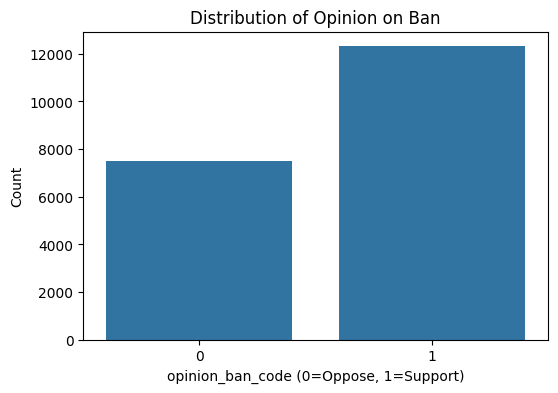

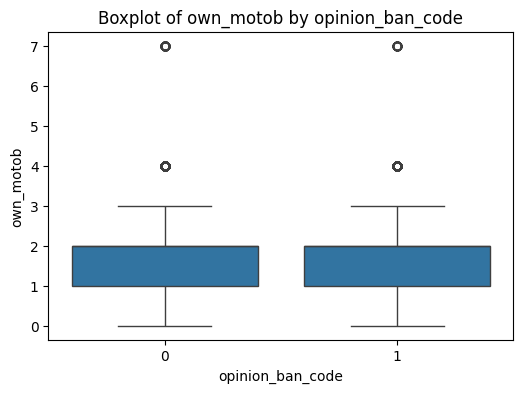


Summary Statistics for 'own_motob':
Mean: 1.81
Median: 2.0
Mode: 2
Standard Deviation: 0.87
Skewness: 1.29
Kurtosis: 6.69


In [ ]:

# from scipy.stats import skew, kurtosis


# # Ensure required columns are in the DataFrame
# df_model = df_model[['opinion_ban_code', 'own_motob']].dropna()

# # Frequency table for opinion_ban_code
# freq_table = df_model['opinion_ban_code'].value_counts().reset_index()
# freq_table.columns = ['Opinion (0=Oppose, 1=Support)', 'Count']
# freq_table['Percentage'] = 100 * freq_table['Count'] / freq_table['Count'].sum()
# print("Frequency Table:\n", freq_table)

# # Bar chart
# plt.figure(figsize=(6, 4))
# sns.countplot(x='opinion_ban_code', data=df_model)
# plt.title('Distribution of Opinion on Ban')
# plt.xlabel('opinion_ban_code (0=Oppose, 1=Support)')
# plt.ylabel('Count')
# plt.show()

# # Boxplot of own_motob by opinion
# plt.figure(figsize=(6, 4))
# sns.boxplot(x='opinion_ban_code', y='own_motob', data=df_model)
# plt.title('Boxplot of own_motob by opinion_ban_code')
# plt.xlabel('opinion_ban_code')
# plt.ylabel('own_motob')
# plt.show()

# # Summary statistics for own_motob
# mean_val = df_model['own_motob'].mean()
# median_val = df_model['own_motob'].median()
# mode_val = df_model['own_motob'].mode()[0]
# std_dev = df_model['own_motob'].std()
# skew_val = skew(df_model['own_motob'])
# kurt_val = kurtosis(df_model['own_motob'])

# print("\nSummary Statistics for 'own_motob':")
# print(f"Mean: {mean_val:.2f}")
# print(f"Median: {median_val}")
# print(f"Mode: {mode_val}")
# print(f"Standard Deviation: {std_dev:.2f}")
# print(f"Skewness: {skew_val:.2f}")
# print(f"Kurtosis: {kurt_val:.2f}")

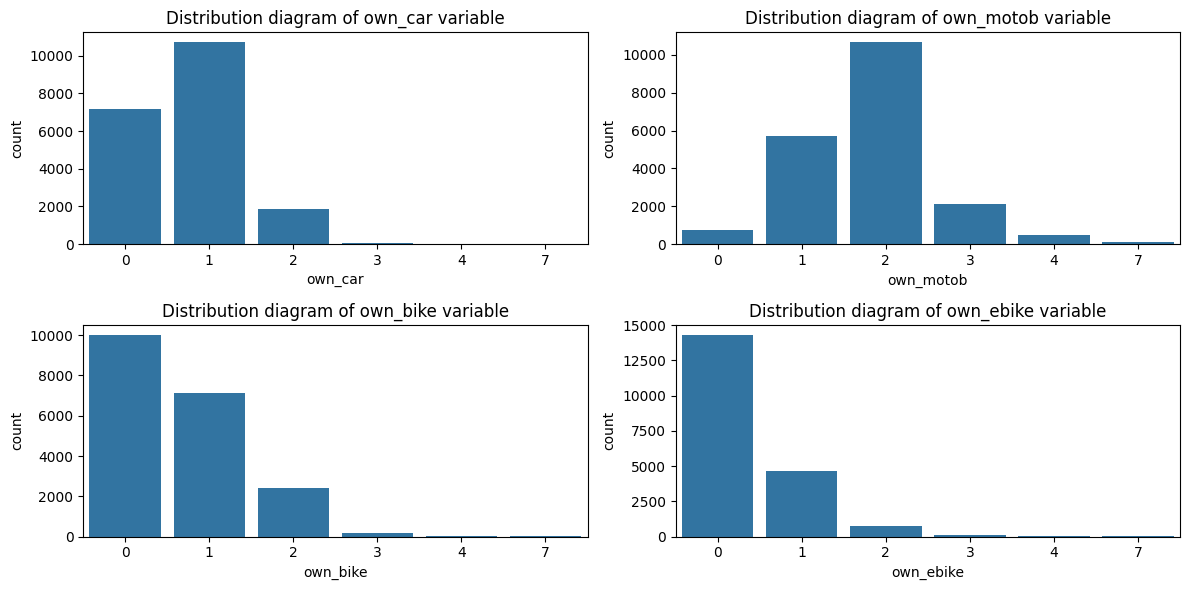

In [74]:
cat_vars = ['own_car', 'own_motob', 'own_bike', 'own_ebike']

plt.figure(figsize=(12, 6))
for i, var in enumerate(cat_vars):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=var, data=df_model, width=0.85)
    plt.title(f'Distribution diagram of {var} variable')

plt.tight_layout()
plt.show()

In [83]:
from scipy.stats import pointbiserialr

cat_vars = ['own_car', 'own_motob', 'own_bike', 'own_ebike']

for var in cat_vars: 
    corr, p_value = pointbiserialr(df_model['opinion_ban_code'], df_model[var])
    print(f"Correlation of opinion_ban and {var}: {corr:.4f}, P-value: {p_value:.4f}")

Correlation of opinion_ban and own_car: 0.3539, P-value: 0.0000
Correlation of opinion_ban and own_motob: -0.0233, P-value: 0.0010
Correlation of opinion_ban and own_bike: 0.1625, P-value: 0.0000
Correlation of opinion_ban and own_ebike: -0.0460, P-value: 0.0000


In [78]:
# Frequency table
frequency_table = df_model['opinion_ban_code'].value_counts().sort_index()
percentage_table = round(frequency_table / frequency_table.sum() * 100, 2)

# Combine into a DataFrame for display
freq_df = pd.DataFrame({
    'Opinion (0 = Oppose, 1 = Support)': frequency_table.index,
    'Count': frequency_table.values,
    'Percentage': percentage_table.values
})

print("Frequency Table for 'opinion_ban_code':")
print(freq_df)

Frequency Table for 'opinion_ban_code':
   Opinion (0 = Oppose, 1 = Support)  Count  Percentage
0                                  0   7487        37.8
1                                  1  12320        62.2


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_7664\601543487.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='opinion_ban_code', data=df_model, palette='pastel')


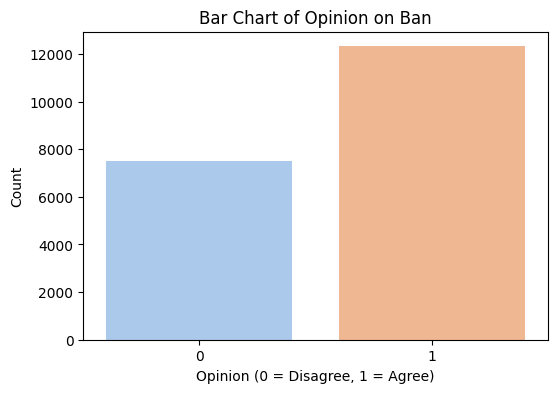

In [77]:
plt.figure(figsize=(6, 4))
sns.countplot(x='opinion_ban_code', data=df_model, palette='pastel')
plt.title('Bar Chart of Opinion on Ban')
plt.xlabel('Opinion (0 = Disagree, 1 = Agree)')
plt.ylabel('Count')
plt.show()

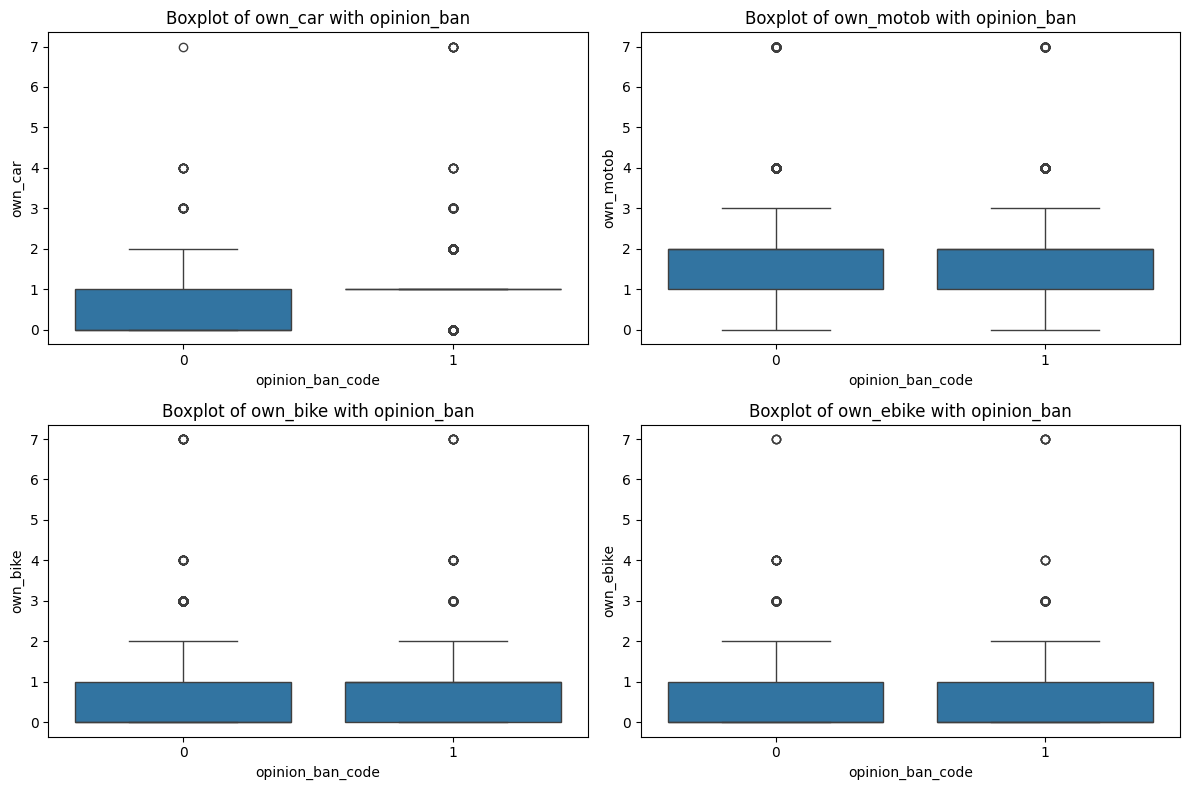


Summary Statistics for 'own_car' grouped by opinion_ban:

  Group opinion_ban_code = 0:
    Mean: 0.45
    Median: 0.00
    Mode: 0
    Std Dev: 0.57
    Skewness: 1.25
    Kurtosis: 3.88

  Group opinion_ban_code = 1:
    Mean: 0.92
    Median: 1.00
    Mode: 1
    Std Dev: 0.63
    Skewness: 0.74
    Kurtosis: 5.57

Summary Statistics for 'own_motob' grouped by opinion_ban:

  Group opinion_ban_code = 0:
    Mean: 1.84
    Median: 2.00
    Mode: 2
    Std Dev: 1.04
    Skewness: 1.33
    Kurtosis: 4.65

  Group opinion_ban_code = 1:
    Mean: 1.80
    Median: 2.00
    Mode: 2
    Std Dev: 0.74
    Skewness: 1.01
    Kurtosis: 7.82

Summary Statistics for 'own_bike' grouped by opinion_ban:

  Group opinion_ban_code = 0:
    Mean: 0.49
    Median: 0.00
    Mode: 0
    Std Dev: 0.75
    Skewness: 2.31
    Kurtosis: 10.17

  Group opinion_ban_code = 1:
    Mean: 0.74
    Median: 1.00
    Mode: 0
    Std Dev: 0.77
    Skewness: 0.88
    Kurtosis: 1.96

Summary Statistics for 'own_ebike' 

In [81]:
cat_vars = ['own_car', 'own_motob', 'own_bike', 'own_ebike']
target = 'opinion_ban_code'

plt.figure(figsize=(12, 8))

for i, var in enumerate(cat_vars):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=target, y=var, data=df_model)
    plt.title(f'Boxplot of {var} with opinion_ban')
    plt.xlabel('opinion_ban_code')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

from scipy.stats import skew, kurtosis

for var in cat_vars:
    print(f"\nSummary Statistics for '{var}' grouped by opinion_ban:")
    for val in sorted(df_model[target].unique()):
        group = df_model[df_model[target] == val][var]
        print(f"\n  Group {target} = {val}:")
        print(f"    Mean: {group.mean():.2f}")
        print(f"    Median: {group.median():.2f}")
        print(f"    Mode: {group.mode().iloc[0] if not group.mode().empty else 'N/A'}")
        print(f"    Std Dev: {group.std():.2f}")
        print(f"    Skewness: {skew(group):.2f}")
        print(f"    Kurtosis: {kurtosis(group):.2f}")


In [54]:
from scipy.stats import mannwhitneyu

for var in ['own_car', 'own_motob', 'own_bike', 'own_ebike']:
    group0 = df_model[df_model['opinion_ban_code'] == 0][var]
    group1 = df_model[df_model['opinion_ban_code'] == 1][var]
    
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    print(f'{var}: Mann-Whitney U statistic = {stat:.2f}, p-value = {p:.4f}')

own_car: Mann-Whitney U statistic = 27808386.50, p-value = 0.0000
own_motob: Mann-Whitney U statistic = 45317956.00, p-value = 0.0231
own_bike: Mann-Whitney U statistic = 36787340.00, p-value = 0.0000
own_ebike: Mann-Whitney U statistic = 47664040.00, p-value = 0.0000


In [9]:
# 3. Chuẩn bị biến độc lập và phụ thuộc
y = df_model['opinion_ban_code']
X = df_model.drop(['opinion_ban', 'opinion_ban_code','vehic_moto'], axis=1)

# #Chuẩn hóa dữ liệu
# scaler = StandardScaler()
# num_cols = ['age', 'opinion_car', 'opinion_motob', 'opinion_ebike','opinion_bike', 'opinion_bus']
# X[num_cols] = scaler.fit_transform(X[num_cols])

In [ ]:
# 4. Xây dựng mô hình Ordered Logit
# mod_log = OrderedModel(y, X, distr='logit')

# # Ước lượng mô hình
# res_log = mod_log.fit(method='lbfgs', maxiter=2000, gtol=1e-5, disp=True)
# print(res_log.summary())
    
#     # 5. Đánh giá mô hình
#     # Hiển thị các hệ số quan trọng
# params = res_log.params
# conf_int = res_log.conf_int()
# conf_int.columns = ['2.5%', '97.5%']
# results_df = pd.DataFrame({'coef': params, 'conf_lower': conf_int['2.5%'], 
#                               'conf_upper': conf_int['97.5%']})
    
#     # Lọc các biến có ý nghĩa thống kê (p-value < 0.1)
# significant_vars = results_df[res_log.pvalues < 0.1].sort_values(by='coef', ascending=False)
    
# print("\nCác biến có ảnh hưởng quan trọng:")
# print(significant_vars)

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: gtol. After release 0.14, this will raise.
  warnings.warn(


                             OrderedModel Results                             
Dep. Variable:       opinion_ban_code   Log-Likelihood:                -24296.
Model:                   OrderedModel   AIC:                         4.863e+04
Method:            Maximum Likelihood   BIC:                         4.881e+04
Date:                Fri, 16 May 2025                                         
Time:                        11:06:36                                         
No. Observations:               26105                                         
Df Residuals:                   26084                                         
Df Model:                          19                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
freqpweek        -0.0334      0.003    -10.585      0.000      -0.040      -0.027
freq_car          0.1470      0.004     38.

In [22]:
def mcfadden_rsquared(model):
    llf = model.llf
    llnull = model.llnull
    return 1 - (llf/llnull)

pseudo_r2 = mcfadden_rsquared(res_log)
print(f"McFadden's Pseudo R-squared: {pseudo_r2:.4f}")

McFadden's Pseudo R-squared: 0.1184


In [23]:
from sklearn.metrics import accuracy_score

pred_prob = res_log.predict()
pred_class = np.argmax(pred_prob, axis=1)

y_true = res_log.model.endog

accuracy = accuracy_score(y_true, pred_class)
print(f"Tỷ lệ dự đoán đúng: {accuracy * 100:.2f}%")

Tỷ lệ dự đoán đúng: 58.46%


In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# Ma trận nhầm lẫn
cm = confusion_matrix(y_true, pred_class)
print("Confusion Matrix:")
print(cm)

# Báo cáo phân loại (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_true, pred_class, target_names=["Disagree", "Neutral", "Agree"]))

Confusion Matrix:
[[ 5106     0  2381]
 [ 2516     0  3782]
 [ 2165     0 10155]]

Classification Report:
              precision    recall  f1-score   support

    Disagree       0.52      0.68      0.59      7487
     Neutral       0.00      0.00      0.00      6298
       Agree       0.62      0.82      0.71     12320

    accuracy                           0.58     26105
   macro avg       0.38      0.50      0.43     26105
weighted avg       0.44      0.58      0.50     26105



c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [25]:
wald_test = res_log.wald_test_terms()
print(wald_test)

                                    chi2                   P>chi2  df constraint
freqpweek          [[112.0482431293298]]    3.487206166983272e-26              1
freq_car          [[1514.5583054692484]]                      0.0              1
dist_to_pub       [[128.39677710653186]]    9.190478513920404e-30              1
own_car            [[334.2961755560912]]   1.1145321965505146e-74              1
own_motob          [[29.94696005147557]]   4.4402748885846376e-08              1
own_bike          [[16.527653598941516]]    4.794568958464854e-05              1
own_ebike         [[23.203112298435784]]   1.4576123804696764e-06              1
aware_ban_no      [[40.737891972021565]]    1.740787105262631e-10              1
aware_ban_yes      [[942.5052498014612]]  5.6483815305008404e-207              1
vehic_bus        [[0.21556303084075196]]       0.6424416641412646              1
vehic_car         [[115.28933880719809]]    6.801348826629505e-27              1
vehic_ebike       [[33.94712

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [84]:
from statsmodels.discrete.discrete_model import Logit

model_logit = Logit(y,X)

result_logit = model_logit.fit()

print(result_logit.summary())

Optimization terminated successfully.
         Current function value: 0.465044
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       opinion_ban_code   No. Observations:                19807
Model:                          Logit   Df Residuals:                    19788
Method:                           MLE   Df Model:                           18
Date:                Fri, 16 May 2025   Pseudo R-squ.:                  0.2987
Time:                        19:51:18   Log-Likelihood:                -9211.1
converged:                       True   LL-Null:                       -13134.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
freqpweek        -0.0556      0.005    -12.176      0.000      -0.065      -0.047
freq_car          0.

In [93]:
print(result_logit.get_margeff(at='overall').summary())

        Logit Marginal Effects       
Dep. Variable:       opinion_ban_code
Method:                          dydx
At:                           overall
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
freqpweek        -0.0086      0.001    -12.362      0.000      -0.010      -0.007
freq_car          0.0457      0.001     44.280      0.000       0.044       0.048
dist_to_pub   -7.134e-06   3.71e-06     -1.924      0.054   -1.44e-05    1.35e-07
own_car           0.1108      0.005     20.777      0.000       0.100       0.121
own_motob        -0.0245      0.003     -7.580      0.000      -0.031      -0.018
own_bike          0.0536      0.004     13.289      0.000       0.046       0.061
own_ebike        -0.0549      0.005    -10.603      0.000      -0.065      -0.045
aware_ban_no      0.1067      0.010     11.011      0.000       0.088       0.126
aware_ban_yes     0.2768    

In [ ]:
from statsmodels.discrete.discrete_model import MNLogit

model = MNLogit(y, X)
result = model.fit_regularized(
   alpha=0.01,
    L1_wt=0.5,
    maxiter=2000,
    tol=1e-6
    )

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.900177847339472
            Iterations: 82
            Function evaluations: 170
            Gradient evaluations: 82


c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 38 out of 38 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [27]:
print(result.summary())

                          MNLogit Regression Results                          
Dep. Variable:       opinion_ban_code   No. Observations:                26105
Model:                        MNLogit   Df Residuals:                    26067
Method:                           MLE   Df Model:                           36
Date:                Fri, 16 May 2025   Pseudo R-squ.:                  0.1473
Time:                        11:06:40   Log-Likelihood:                -23499.
converged:                       True   LL-Null:                       -27557.
Covariance Type:            nonrobust   LLR p-value:                     0.000
opinion_ban_code=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
freqpweek             -0.0170      0.004     -4.008      0.000      -0.025      -0.009
freq_car               0.2088      0.008     27.544      0.000       0.194       0.224
dist_to_pub         

In [36]:
model = sm.MNLogit(y, X)
result = model.fit(method="newton", maxiter=1000)  # Không dùng start_params
mfx = result.get_margeff(at='overall')
print(mfx.summary())

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Optimization terminated successfully.
         Current function value: nan
         Iterations 8
       MNLogit Marginal Effects      
Dep. Variable:       opinion_ban_code
Method:                          dydx
At:                           overall
opinion_ban_code=0      dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
x1                     0.0224      0.003      8.504      0.000       0.017       0.028
x2                    -0.1535      0.004    -38.283      0.000      -0.161      -0.146
x3                     7.4929      0.186     40.392      0.000       7.129       7.856
x4                    -0.0494      0.003    -14.849      0.000      -0.056      -0.043
x5                     0.0190      0.003      7.501      0.000       0.014       0.024
x6                    -0.0350      0.003    -11.968      0.000      -0.041      -0.029
x7                     0.0130      0.003      4.554    

In [ ]:
used_names = [name for name in result.model.exog_names if name != 'const']

assert len(used_names) == mfx.margeff.shape[0]
me_df = pd.DataFrame(mfx.margeff, columns=['opinion_0', 'opinion_1', 'opinion_2'])
me_df['variable'] = used_names

df_plot = me_df.melt(id_vars='variable',
                     value_vars=['opinion_0', 'opinion_1', 'opinion_2'],
                     var_name='Opinion', value_name='Marginal_Effect')

df_plot['Opinion'] = df_plot['Opinion'].map({
    'opinion_0': 'Phản đối',
    'opinion_1': 'Trung lập',
    'opinion_2': 'Ủng hộ'
})



AttributeError: 'Summary' object has no attribute 'margeff'

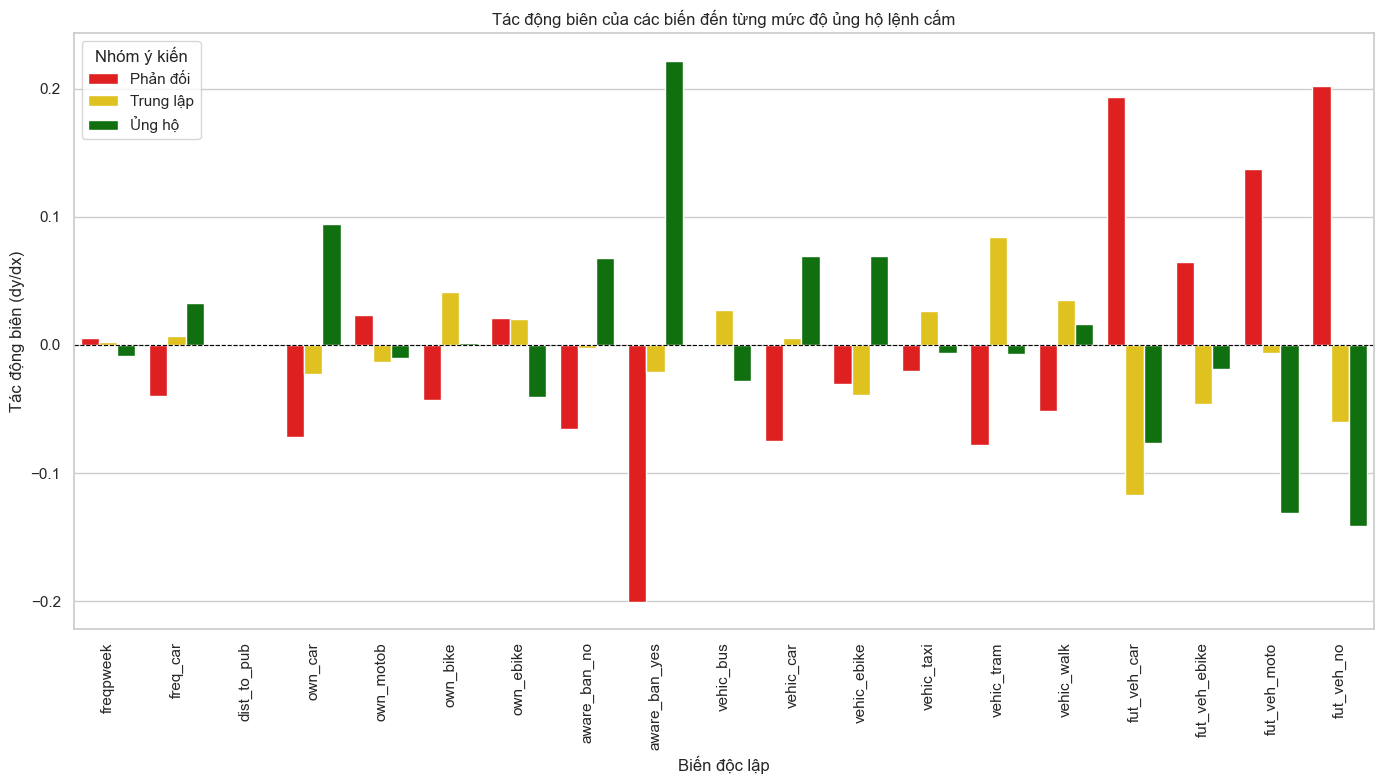

In [ ]:
# Long format
df_plot = me_df.melt(id_vars='variable',
                     value_vars=['opinion_0', 'opinion_1'],
                     var_name='Opinion', value_name='Marginal_Effect')

df_plot['Opinion'] = df_plot['Opinion'].map({
    'opinion_0': 'Disagree',
    'opinion_1': 'Agree'
})

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.set_theme(style='whitegrid')
sns.barplot(data=df_plot, x='variable', y='Marginal_Effect', hue='Opinion',
            palette=['red', 'green'])

plt.xticks(rotation=90)
plt.title("Marginal effects of variables on each level of support for the ban")
plt.xlabel("Independent Variables")
plt.ylabel("Marginal Effect (dy/dx)")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(title='Group')
plt.tight_layout()
plt.show()


In [37]:
print(result.summary())

                          MNLogit Regression Results                          
Dep. Variable:       opinion_ban_code   No. Observations:                26105
Model:                        MNLogit   Df Residuals:                    26067
Method:                           MLE   Df Model:                           36
Date:                Fri, 16 May 2025   Pseudo R-squ.:                     nan
Time:                        11:10:52   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -27557.
Covariance Type:            nonrobust   LLR p-value:                       nan
opinion_ban_code=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
x1                    -0.0553      0.018     -3.076      0.002      -0.090      -0.020
x2                     0.7151      0.027     26.938      0.000       0.663       0.767
x3                  

In [32]:
me_summary.filter(like='dy/dx', axis=1)


NameError: name 'me_summary' is not defined

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=10)  # chọn 10 biến tốt nhất
X_new = selector.fit_transform(X, y)

mask = selector.get_support()

# In tên 10 biến được chọn
selected_features = X.columns[mask]

X_new = selector.transform(X)
X_new_df = pd.DataFrame(X_new, columns=selected_features)

model1 = sm.MNLogit(y, X_new_df)
result1 = model1.fit(method="newton", maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.922774
         Iterations 7


c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [39]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X, y)

print("Intercepts (hệ số chặn):")
print(model.intercept_)

print("\nCoefficients (hệ số hồi quy):")
print(model.coef_)

Intercepts (hệ số chặn):
[-0.39191259 -0.09376899  0.48568158]

Coefficients (hệ số hồi quy):
[[ 8.11031401e-02 -7.12263404e-01 -1.22946938e-02 -1.92514775e-01
   7.72124960e-02 -1.50723131e-01  4.80510722e-02 -1.10098315e-01
  -3.96294216e-01 -3.23593249e-03 -1.40121475e-01 -2.93503507e-02
  -1.39534476e-02 -7.12559439e-03 -3.28138655e-02  2.42022297e-01
  -3.11938482e-03  1.04279299e-01  2.57771159e-01]
 [ 2.06031439e-02  1.99164863e-01  5.02258521e-02 -3.36964355e-02
  -6.18270472e-02  1.33389010e-01  3.72690817e-02  8.83609637e-04
   5.16160342e-03  1.01281233e-02  2.37999088e-02 -2.97634492e-02
   1.11436243e-02  7.36380641e-03  2.04120053e-02 -2.47540745e-01
  -4.40746462e-02 -4.47223086e-02 -1.63782259e-01]
 [-1.01706284e-01  5.13098540e-01 -3.79311583e-02  2.26211211e-01
  -1.53854488e-02  1.73341206e-02 -8.53201540e-02  1.09214706e-01
   3.91132612e-01 -6.89219080e-03  1.16321566e-01  5.91137999e-02
   2.80982321e-03 -2.38212029e-04  1.24018602e-02  5.51844833e-03
   4.7194031

In [ ]:
print(result1.summary())

                          MNLogit Regression Results                          
Dep. Variable:       opinion_ban_code   No. Observations:                26105
Model:                        MNLogit   Df Residuals:                    26085
Method:                           MLE   Df Model:                           18
Date:                Thu, 15 May 2025   Pseudo R-squ.:                  0.1259
Time:                        23:59:14   Log-Likelihood:                -24089.
converged:                       True   LL-Null:                       -27557.
Covariance Type:            nonrobust   LLR p-value:                     0.000
opinion_ban_code=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
freqpweek             -0.0628      0.004    -16.886      0.000      -0.070      -0.055
freq_car               0.2020      0.008     26.528      0.000       0.187       0.217
own_car             

In [ ]:
# n_bootstraps = 100
# coefs_bootstrap = []

# for _ in range(n_bootstraps):
#     sample_df = df_model.sample(frac=1, replace=True)
#     y_boot = sample_df['opinion_ban_code']
#     X_boot = sample_df.drop(['opinion_ban', 'opinion_ban_code'], axis=1)

#     model_boot = MNLogit(y_boot, X_boot)
#     result_boot = model_boot.fit_regularized(alpha=0.01, L1_wt=0.5, maxiter=2000, tol=1e-6)
#     coefs_bootstrap.append(result_boot.params)

# # Chuyển thành DataFrame
# coefs_bootstrap_df = pd.concat(coefs_bootstrap, axis=1)

# # Tính khoảng tin cậy 95%
# ci_lower = coefs_bootstrap_df.quantile(0.025, axis=1)
# ci_upper = coefs_bootstrap_df.quantile(0.975, axis=1)

# # Hiển thị
# coef_summary = pd.DataFrame({'coef_mean': np.mean(coefs_bootstrap_df, axis=1),
#                              'CI_lower': ci_lower,
#                              'CI_upper': ci_upper})
# print(coef_summary)

In [ ]:
# df = coef_summary.copy()
# df['significant'] = (df['CI_lower'] * df['CI_upper']) > 0  # true nếu cùng dấu

# # Vẽ biểu đồ với màu sắc phân biệt
# colors = df['significant'].map({True: 'green', False: 'gray'})
# df['coef_mean'].plot(kind='barh', xerr=[df['coef_mean'] - df['CI_lower'], df['CI_upper'] - df['coef_mean']],
#                      color=colors, alpha=0.7, figsize=(10, 8))
# plt.axvline(0, color='black', linestyle='--')
# plt.title("Hệ số và khoảng tin cậy 95% (bootstrap)")
# plt.xlabel("Giá trị trung bình hệ số")
# plt.tight_layout()
# plt.show()

In [85]:
def analyze_important_variables(result, threshold=0.01, top_n=20, plot=True):
    """
    Phân tích các biến quan trọng từ mô hình MNLogit đã được fit_regularized.
    
    Parameters:
    - result: đối tượng kết quả từ model.fit_regularized()
    - threshold: hệ số tuyệt đối > threshold sẽ được xem là quan trọng (mặc định: 0.01)
    - top_n: số lượng biến quan trọng nhất để hiển thị
    - plot: có vẽ biểu đồ hay không
    
    Returns:
    - DataFrame chứa các biến và hệ số tương ứng
    """
    coefs = result.params.copy()
    
    # Lấy độ lớn tuyệt đối lớn nhất cho mỗi biến qua các class (trong multinomial)
    max_abs_coef = coefs.abs().max(axis=1)
    
    # Lọc các biến quan trọng theo ngưỡng
    important = max_abs_coef[max_abs_coef > threshold].sort_values(ascending=False).head(top_n)
    
    if plot:
        important.plot(kind='barh', figsize=(10, 6))
        plt.gca().invert_yaxis()
        plt.title("Top variables with the largest impact based on coefficient magnitude (max |coef|)")
        plt.xlabel("The largest absolute value of the coefficient")
        plt.tight_layout()
        plt.show()
    
    return coefs.loc[important.index]

important_vars = analyze_important_variables(result_logit, threshold=0.01, top_n=20, plot=True)
print(important_vars)

ValueError: No axis named 1 for object type Series

In [ ]:
lr_stat = 2 * (result.llf - res_log.llf)
p_value = 1 - stats.chi2.cdf(lr_stat, df=result.df_model - res_log.df_model)
print(f"LR p-value: {p_value:.4f}")
# Nếu p-value < 0.05 → Vi phạm proportional odds

LR p-value: 0.0000


In [ ]:
# ll_null = null_res.llf
# print("Log-Likelihood (null model):", ll_null)

In [ ]:
df_model[['opinion_ban','opinion_ban_code']].value_counts()

opinion_ban     opinion_ban_code
agree           2                   10608
neutral         1                    6298
disagree        0                    5746
strongdisagree  0                    1741
strongagree     2                    1712
Name: count, dtype: int64

In [ ]:
# # Thêm tương tác giữa sở hữu xe và đánh giá phương tiện
# X['car_owner_x_opinion'] = X['own_car'] * X['opinion_car']
# X['moto_owner_x_opinion'] = X['own_motob'] * X['opinion_motob']

# # X_reduced = X_reduced.drop(columns=['own_car', 'own_motob', 'opinion_car', 'opinion_motob'])

# mod_interaction = OrderedModel(y, X, distr='logit')
# res_interaction = mod_interaction.fit(method='bfgs', maxiter=1000)

In [86]:
coef = result_logit.params
odds_ratio = np.exp(coef)
percent_change = (odds_ratio - 1) * 100  # đổi sang %

# Tạo bảng tóm tắt
summary_df = pd.DataFrame({
    'Variable': coef.index,
    'Coef': coef.values,
    'Odds_Ratio': odds_ratio,
    'Percent_Change (%)': percent_change
})

# Lấy top 10 biến theo độ lớn ảnh hưởng
top10 = summary_df.reindex(percent_change.abs().sort_values(ascending=False).index).head(10)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_7664\4089075518.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


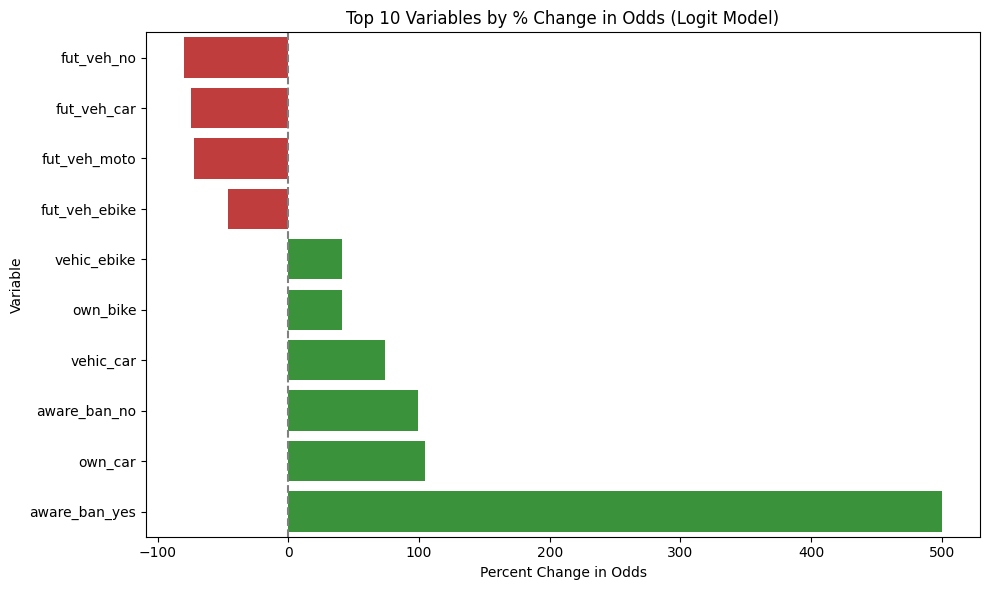

In [92]:
top10_sorted = top10.sort_values(by='Percent_Change (%)')

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_sorted,
    x='Percent_Change (%)',
    y='Variable',
    palette=['#d62728' if x < 0 else '#2ca02c' for x in top10_sorted['Percent_Change (%)']]
)

plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Top 10 Variables by % Change in Odds (Logit Model)')
plt.xlabel('Percent Change in Odds')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [ ]:
# print(res_interaction.summary())

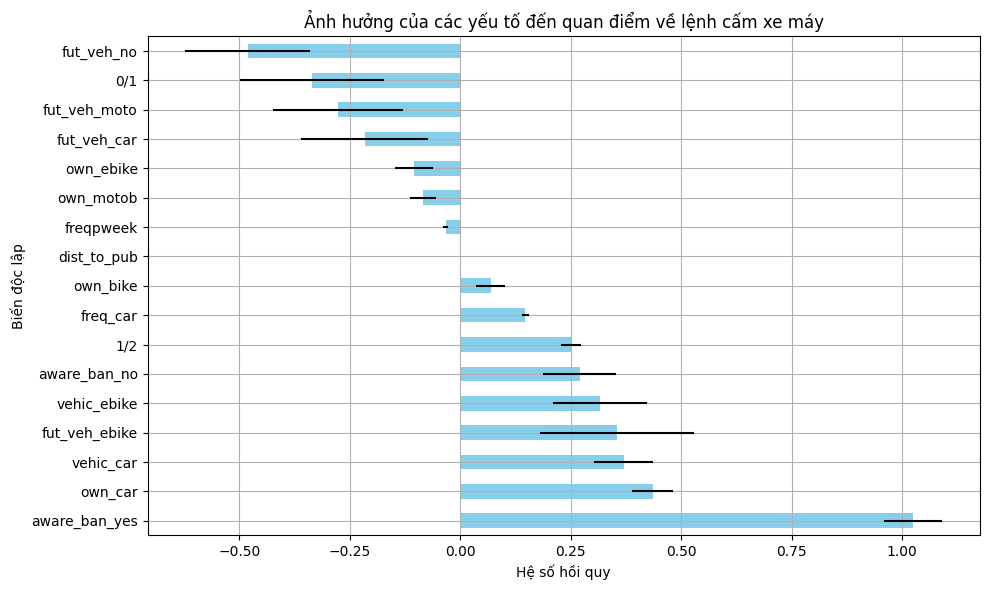

In [ ]:
# 6. Trực quan hóa kết quả
plt.figure(figsize=(10, 6))
significant_vars['coef'].plot(kind='barh', 
                                 xerr=[significant_vars['coef']-significant_vars['conf_lower'], 
                                       significant_vars['conf_upper']-significant_vars['coef']],
                                 color='skyblue')
plt.title('Ảnh hưởng của các yếu tố đến quan điểm về lệnh cấm xe máy')
plt.xlabel('Hệ số hồi quy')
plt.ylabel('Biến độc lập')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## Kiểm định Đa Cộng Tuyến
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                  for i in range(X.shape[1])]
print(vif_data.sort_values("VIF", ascending=False))

         Variable       VIF
4       own_motob  5.540606
8   aware_ban_yes  4.287082
15    fut_veh_car  4.222683
18     fut_veh_no  4.186831
0       freqpweek  3.848522
3         own_car  3.229560
17   fut_veh_moto  3.112854
5        own_bike  1.997594
7    aware_ban_no  1.965455
10      vehic_car  1.859159
1        freq_car  1.834422
6       own_ebike  1.580279
16  fut_veh_ebike  1.521533
11    vehic_ebike  1.133303
14     vehic_walk  1.056302
9       vehic_bus  1.044712
12     vehic_taxi  1.033351
13     vehic_tram  1.001753
2     dist_to_pub  1.000428


Optimization terminated successfully.
         Current function value: 0.930337
         Iterations: 124
         Function evaluations: 131
         Gradient evaluations: 131
                             OrderedModel Results                             
Dep. Variable:       opinion_ban_code   Log-Likelihood:                -24286.
Model:                   OrderedModel   AIC:                         4.861e+04
Method:            Maximum Likelihood   BIC:                         4.879e+04
Date:                Thu, 15 May 2025                                         
Time:                        21:42:23                                         
No. Observations:               26105                                         
Df Residuals:                   26084                                         
Df Model:                          19                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

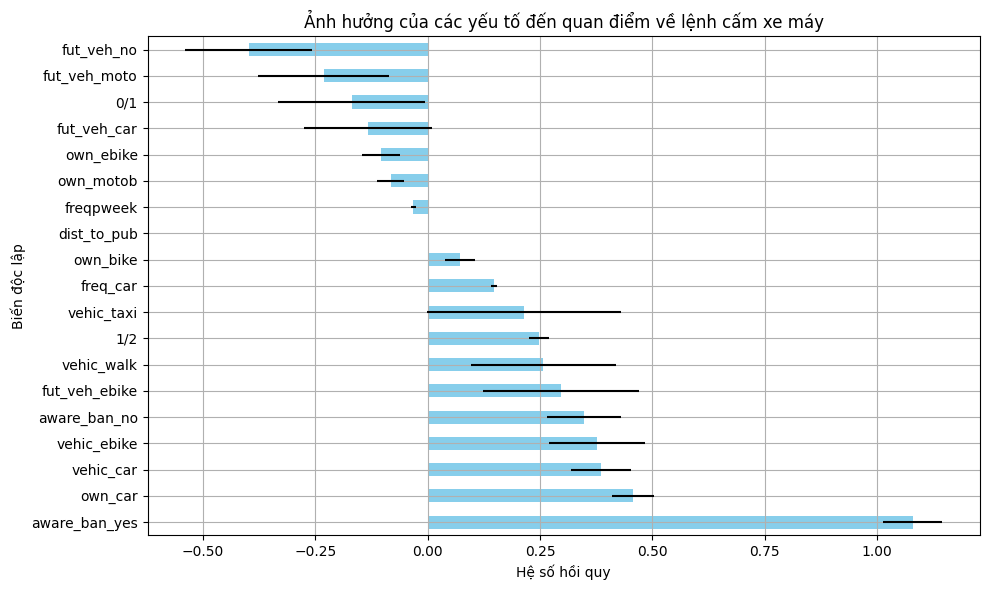

ValueError: operands could not be broadcast together with shapes (26105,) (26105,3) 

In [ ]:
# 4. Xây dựng mô hình Ordered Logit
mod_log = OrderedModel(y, X, distr='logit')

# Ước lượng mô hình
res_log = mod_log.fit(method='bfgs', maxiter=1000)
print(res_log.summary())
    
    # 5. Đánh giá mô hình
    # Hiển thị các hệ số quan trọng
params = res_log.params
conf_int = res_log.conf_int()
conf_int.columns = ['2.5%', '97.5%']
results_df = pd.DataFrame({'coef': params, 'conf_lower': conf_int['2.5%'], 
                              'conf_upper': conf_int['97.5%']})
    
    # Lọc các biến có ý nghĩa thống kê (p-value < 0.1)
significant_vars = results_df[res_log.pvalues < 0.1].sort_values(by='coef', ascending=False)
    
print("\nCác biến có ảnh hưởng quan trọng:")
print(significant_vars)
    
    # 6. Trực quan hóa kết quả
plt.figure(figsize=(10, 6))
significant_vars['coef'].plot(kind='barh', 
                                 xerr=[significant_vars['coef']-significant_vars['conf_lower'], 
                                       significant_vars['conf_upper']-significant_vars['coef']],
                                 color='skyblue')
plt.title('Ảnh hưởng của các yếu tố đến quan điểm về lệnh cấm xe máy')
plt.xlabel('Hệ số hồi quy')
plt.ylabel('Biến độc lập')
plt.grid(True)
plt.tight_layout()
plt.show()
    
    # 7. Dự đoán và đánh giá độ chính xác
predicted_prob = res_log.predict(X)
predicted_class = res_log.model.predict(res_log.params, exog=X)
accuracy = np.mean(predicted_class == y)
print(f"\nĐộ chính xác của mô hình: {accuracy:.2%}")
    
print(f"Lỗi khi ước lượng mô hình: {str(e)}")
print("Kiểm tra lại dữ liệu đầu vào hoặc thử phương pháp tối ưu khác")

In [ ]:
# Thử nghiệm các phương pháp tối ưu khác nhau
# methods = ['bfgs', 'newton', 'lbfgs']
# best_model = None
# best_llf = -np.inf

# for method in methods:
#     try:
#         mod = OrderedModel(y, X, distr='logit')
#         res = mod.fit(method=method, maxiter=1000, disp=0)
#         if res.llf > best_llf:
#             best_model = res
#             best_llf = res.llf
#             print(f"Phương pháp {method} tốt hơn, log-likelihood: {res.llf:.2f}")
#     except:
#         continue

# if best_model is not None:
#     print(best_model.summary())

# # 4. Hiển thị kết quả quan trọng
#     results = pd.DataFrame({
#         'Biến': best_model.params.index,
#         'Hệ số': best_model.params,
#         'P-value': best_model.pvalues
#     })
    
#     significant_results = results[results['P-value'] < 0.05].sort_values('Hệ số', ascending=False)
#     print("\nCác yếu tố ảnh hưởng quan trọng:")
#     print(significant_results)

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Phương pháp bfgs tốt hơn, log-likelihood: -33048.02


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26105 entries, 0 to 26104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freqpweek         26105 non-null  float64
 1   freq_car          26105 non-null  float64
 2   dist_to_pub       26105 non-null  int64  
 3   own_car           26105 non-null  int64  
 4   own_motob         26105 non-null  int64  
 5   own_bike          26105 non-null  int64  
 6   own_ebike         26105 non-null  int64  
 7   opinion_ban       26105 non-null  object 
 8   opinion_ban_code  26105 non-null  int64  
 9   aware_ban_no      26105 non-null  int32  
 10  aware_ban_yes     26105 non-null  int32  
 11  vehic_bus         26105 non-null  int32  
 12  vehic_car         26105 non-null  int32  
 13  vehic_ebike       26105 non-null  int32  
 14  vehic_moto        26105 non-null  int32  
 15  vehic_taxi        26105 non-null  int32  
 16  vehic_tram        26105 non-null  int32 

In [ ]:
from scipy.stats import f_oneway

groups = [df_model[df_model['opinion_ban_code']==g]['own_car'] for g in df_model['opinion_ban_code'].unique()]
fstat, pval = f_oneway(*groups)
print(f"F-statistic: {fstat:.3f}, p-value: {pval:.4f}")

F-statistic: 1342.920, p-value: 0.0000


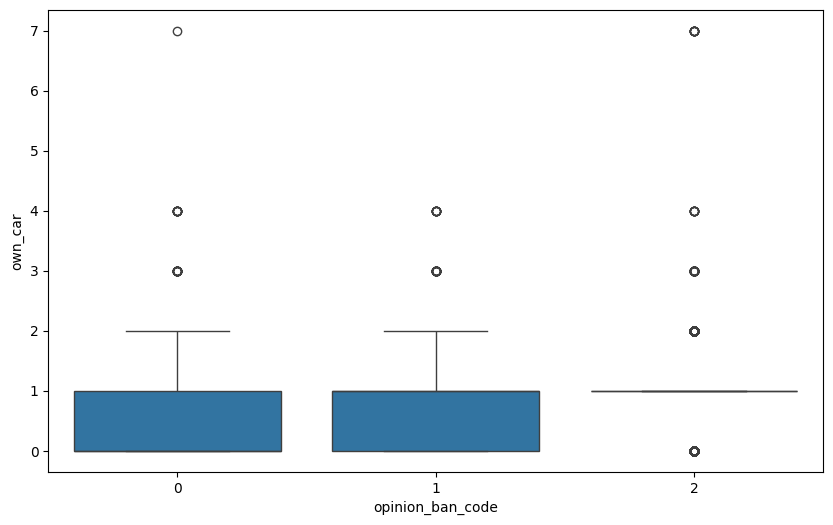

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='opinion_ban_code', y='own_car', data=df_model)
plt.show()

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_18800\3907592294.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='own_car', y='opinion_ban_code', data=df_model, inner='box', palette='Set2')


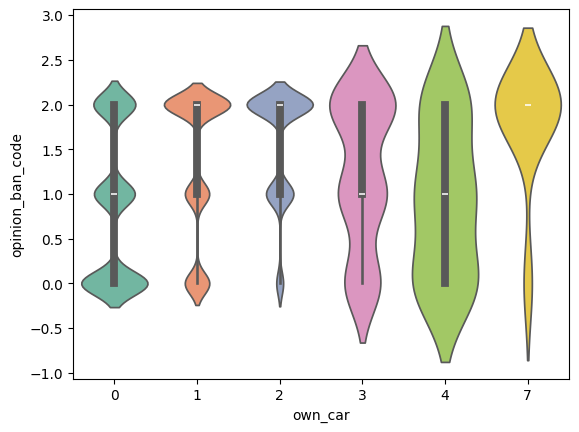

In [ ]:
sns.violinplot(x='own_car', y='opinion_ban_code', data=df_model, inner='box', palette='Set2')
plt.show()

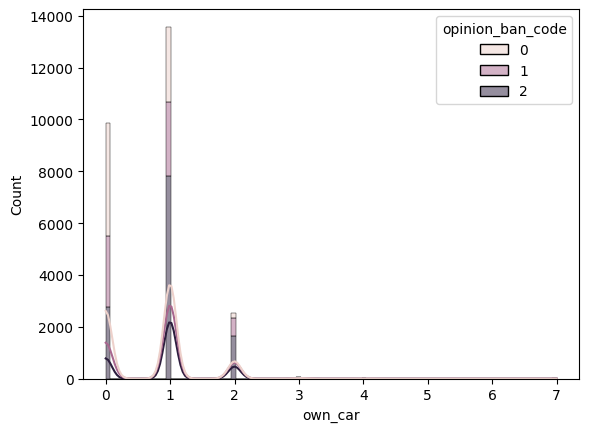

In [ ]:
sns.histplot(data=df_model, x='own_car', hue='opinion_ban_code', kde=True, multiple='stack')
# plt.title('Distribution of own_car by opinion_ban_code')
plt.show()

In [ ]:
from scipy.stats import kruskal

group0 = df_model[df_model['opinion_ban_code'] == 0]['own_car']
group1 = df_model[df_model['opinion_ban_code'] == 1]['own_car']
group2 = df_model[df_model['opinion_ban_code'] == 2]['own_car']

stat, p_value = kruskal(group0, group1, group2)
print(f"Kruskal-Wallis H-statistic: {stat:.3f}")
print(f"p-value: {p_value:.4f}")

Kruskal-Wallis H-statistic: 2734.248
p-value: 0.0000


In [ ]:
from scipy import stats

contingency = pd.crosstab(df_model['opinion_ban_code'], df_model['vehic_moto'])
chi2, p_val_chi2, dof, expected = stats.chi2_contingency(contingency)
print(f"\n Opinion_ban vs vehic_moto:")
print(f"Chi-square = {chi2:.3f}, p-value = {p_val_chi2:.4f}")
if p_val_chi2 < 0.05:
    print("→ Reject H₀, two variables are associated.")
else:
    print("→ Fail to reject H₀, two variables are independent.")


 Opinion_ban vs vehic_moto:
Chi-square = 936.132, p-value = 0.0000
→ Reject H₀, two variables are associated.


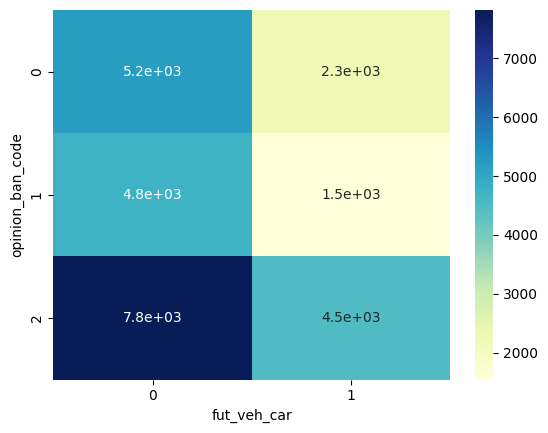

In [ ]:
sns.heatmap(contingency, annot=True, cmap="YlGnBu")
plt.show()

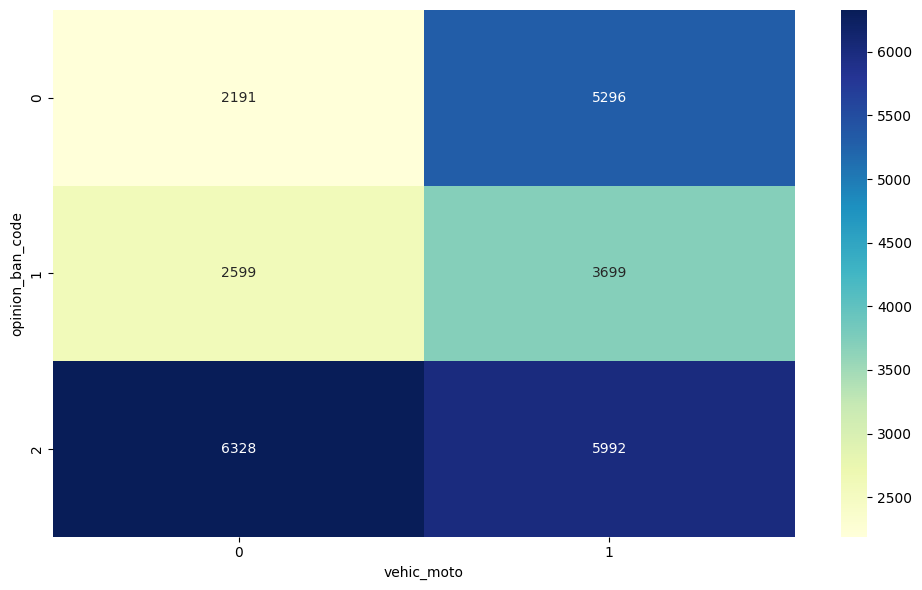

In [ ]:
cat1 = 'opinion_ban_code'
cat2 = 'vehic_moto'

# Create contingency table
contingency_table = pd.crosstab(df_model[cat1], df_model[cat2])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title(f'Contingency Table Heatmap: {cat1} vs {cat2}')
plt.xlabel(cat2)
plt.ylabel(cat1)
plt.tight_layout()
plt.show()

Pearson correlation: -0.071
p-value: 0.0000
→ Reject H₀, there is a significant correlation.


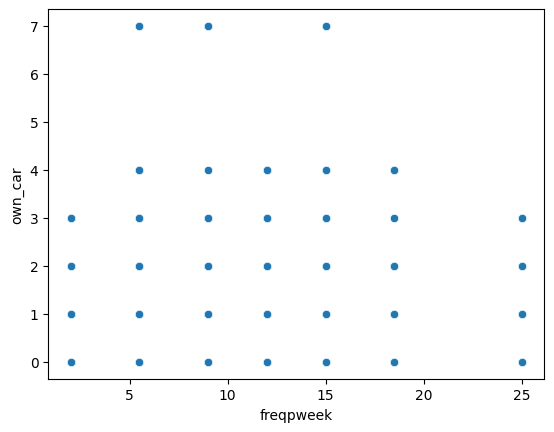

In [ ]:
from scipy import stats

pearson_corr, p_val_pearson = stats.pearsonr(df_model['freqpweek'], df_model['own_car'])

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"p-value: {p_val_pearson:.4f}")

if p_val_pearson < 0.05:
    print("→ Reject H₀, there is a significant correlation.")
else:
    print("→ Fail to reject H₀: No significant correlation.")

# Plot
sns.scatterplot(x=df_model['freqpweek'], y=df_model['own_car'])
plt.show()





In [ ]:
from scipy.stats import spearmanr
corr, p = spearmanr(df_model['freqpweek'], df_model['own_car'])
print(f"Spearmanr correlation: {corr:.3f}")
print(f"p-value: {p:.4f}")

if p_val_pearson < 0.05:
    print("→ Reject H₀, there is a significant correlation.")
else:
    print("→ Fail to reject H₀: No significant correlation.")

Spearmanr correlation: -0.134
p-value: 0.0000
→ Reject H₀, there is a significant correlation.


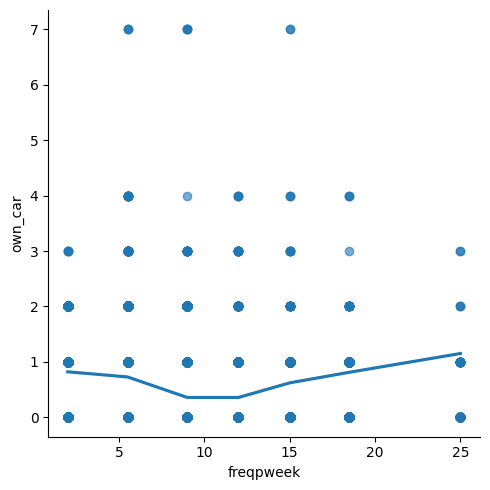

In [ ]:
sns.lmplot(x='freqpweek', y='own_car', data=df_model, lowess=True, scatter_kws={'alpha':0.6})

plt.show()

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_1120\2676451518.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='opinion_ban_code', y='freqpweek', data=df_model, inner='box', palette='Set2')


<Axes: xlabel='opinion_ban_code', ylabel='freqpweek'>

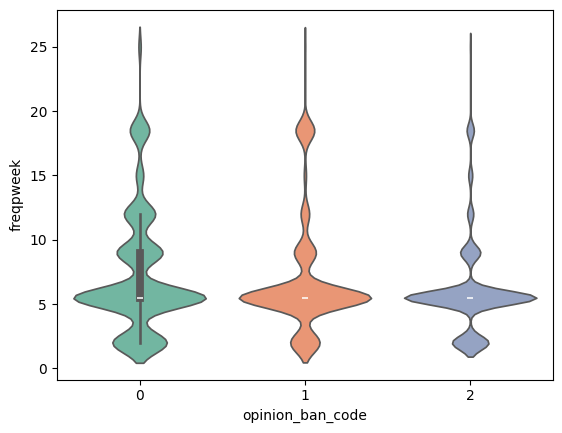

In [ ]:
sns.violinplot(x='opinion_ban_code', y='freqpweek', data=df_model, inner='box', palette='Set2')

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_1120\1407612238.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='own_car', y='freqpweek', data=df_model, palette='pastel')


<Axes: xlabel='own_car', ylabel='freqpweek'>

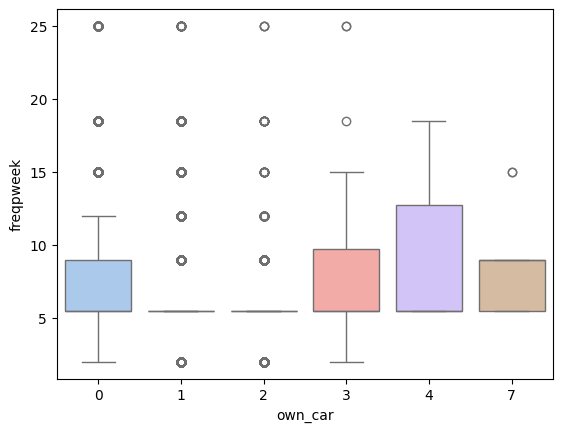

In [ ]:
sns.boxplot(x='own_car', y='freqpweek', data=df_model, palette='pastel')


<Axes: xlabel='own_car', ylabel='Count'>

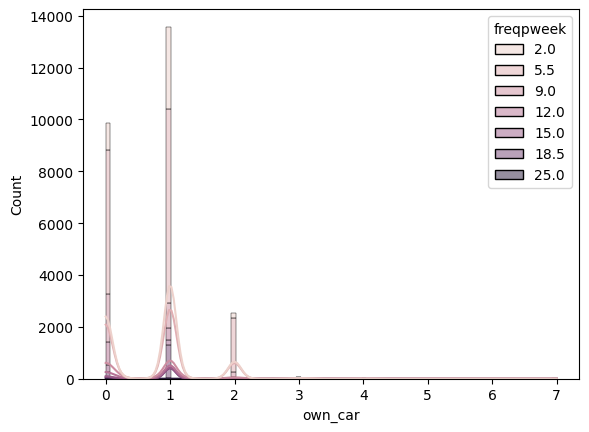

In [ ]:
sns.histplot(data=df_model, x='own_car', hue='freqpweek', kde=True, multiple='stack')


In [ ]:
groups = [df_model[df_model['opinion_ban_code'] == g]['freqpweek'] for g in df_model['opinion_ban_code'].unique()]

stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic: {stat:.3f}")
print(f"p-value: {p_value:.4f}")

Kruskal-Wallis H-statistic: 392.546
p-value: 0.0000


In [ ]:
pred_mnlogit = res_log.predict()
pred_classes = np.argmax(pred_mnlogit, axis=1)  # Choose class with highest prob

from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(df_model['opinion_ban_code'], pred_classes))
print("Confusion Matrix:\n", confusion_matrix(df_model['opinion_ban_code'], pred_classes))

Accuracy: 0.5845623443784715
Confusion Matrix:
 [[ 5151     0  2336]
 [ 2657     0  3641]
 [ 2211     0 10109]]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500))
model.fit(X, y)
y_pred = model.predict(X)

from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


Confusion Matrix:
 [[5106  414 1967]
 [2559  549 3190]
 [2094  404 9822]]
              precision    recall  f1-score   support

           0       0.52      0.68      0.59      7487
           1       0.40      0.09      0.14      6298
           2       0.66      0.80      0.72     12320

    accuracy                           0.59     26105
   macro avg       0.53      0.52      0.48     26105
weighted avg       0.56      0.59      0.54     26105



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Tách dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Cấu hình mô hình XGBoost cơ bản
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Grid các tham số cần tìm
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Khởi tạo GridSearch
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',      # hoặc 'f1_weighted' nếu bạn muốn cân bằng
    cv=3,                    # 3-fold cross-validation
    verbose=1,
    n_jobs=-1                # Dùng toàn bộ CPU
)

# Chạy tìm kiếm
grid_search.fit(X_train, y_train)

# Kết quả tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Dự đoán với mô hình tốt nhất
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:56:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.7054204175445317
Confusion Matrix:
 [[1140  201  156]
 [ 353  569  338]
 [ 254  236 1974]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.76      0.70      1497
           1       0.57      0.45      0.50      1260
           2       0.80      0.80      0.80      2464

    accuracy                           0.71      5221
   macro avg       0.67      0.67      0.67      5221
weighted avg       0.70      0.71      0.70      5221



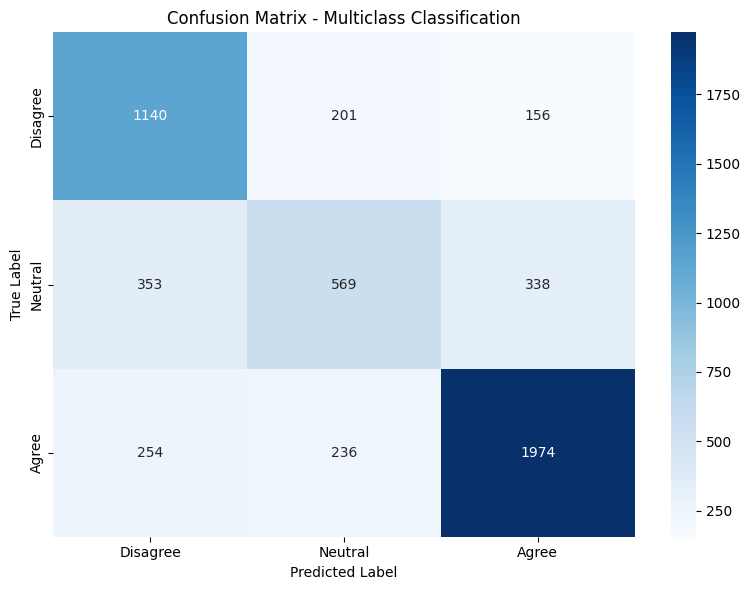

In [ ]:
from sklearn.metrics import confusion_matrix

# Nhãn thực tế và dự đoán
# y_test, y_pred: đầu ra từ model XGBoost của bạn

# Nhãn theo thứ tự đúng
labels = ["Disagree", "Neutral", "Agree"]

# Tạo confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Vẽ
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Multiclass Classification')
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Giả sử bạn có sẵn DataFrame df

# Chia train/test (optional nhưng nên dùng để đánh giá khách quan)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Khởi tạo mô hình XGBoost đa lớp
model = XGBClassifier(
    objective='multi:softprob',     # softmax để dự đoán xác suất
    num_class=3,                    # số lớp (tùy vào dữ liệu của bạn)
    eval_metric='mlogloss',        # log-loss phù hợp cho phân loại đa lớp
    use_label_encoder=False,
    random_state=42
)

# Huấn luyện
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Đánh giá mô hình
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


c:\Users\ThinkPad\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:55:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7019728021451829
Confusion Matrix:
 [[1131  203  163]
 [ 350  565  345]
 [ 250  245 1969]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.76      0.70      1497
           1       0.56      0.45      0.50      1260
           2       0.79      0.80      0.80      2464

    accuracy                           0.70      5221
   macro avg       0.67      0.67      0.66      5221
weighted avg       0.70      0.70      0.70      5221



In [34]:
df_model.isna().sum()

freqpweek           0
freq_car            0
dist_to_pub         0
own_car             0
own_motob           0
own_bike            0
own_ebike           0
opinion_ban         0
opinion_ban_code    0
aware_ban_no        0
aware_ban_yes       0
vehic_bus           0
vehic_car           0
vehic_ebike         0
vehic_moto          0
vehic_taxi          0
vehic_tram          0
vehic_walk          0
fut_veh_car         0
fut_veh_ebike       0
fut_veh_moto        0
fut_veh_no          0
dtype: int64